### Setup

In [8]:
!pip install --no-deps -q bitsandbytes

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install addict transformers==4.46.3 tokenizers==0.20.3 supervision open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00


### OCR

In [3]:
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
import torch

model_name = 'deepseek-ai/DeepSeek-OCR'

In [4]:

from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
"""
Scene Graph Pipeline: Encoder (Object Detection) + Decoder (Relationship Generation)
Processes images to detect objects, then generates relationships between them.
All logs saved to timestamped folder: log_YYMMDDHH
"""

import os
import json
import torch
import itertools
from datetime import datetime
from pathlib import Path
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
from PIL import Image
import sys


# ============================================================================
# CONFIGURATION
# ============================================================================

# Input/Output Paths
os.chdir('/content/drive/MyDrive/AER1515_Assignment1/project/')
IMAGE_INPUT_DIR = "./room1"  # Directory containing input images (jpg/png)
OUTPUT_BASE_DIR = "./logs"  # Base directory for logs

# Model Configuration
MODEL_NAME = 'deepseek-ai/DeepSeek-OCR'

# Generation Parameters
MAX_NEW_TOKENS = 64
TEMPERATURE = 0.0

# Relationship Keywords for Extraction
RELATION_KEYWORDS = [
    "on top of", "under", "next to", "beside", "in front of",
    "behind", "inside", "above", "below", "around",
    "attached to", "leaning against"
]

# ============================================================================
# SETUP LOGGING DIRECTORY
# ============================================================================

def setup_log_directory():
    """Create timestamped log directory."""
    timestamp = datetime.now().strftime("%y%m%d%H")
    log_dir = Path(OUTPUT_BASE_DIR) / f"log_{timestamp}"
    log_dir.mkdir(parents=True, exist_ok=True)

    # Create subdirectories
    (log_dir / "encoder_outputs").mkdir(exist_ok=True)
    (log_dir / "decoder_outputs").mkdir(exist_ok=True)
    (log_dir / "visualizations").mkdir(exist_ok=True)

    return log_dir

# ============================================================================
# ENCODER: OBJECT DETECTION WITH BOUNDING BOXES
# ============================================================================

class ObjectEncoder:
    """Detects objects in images and outputs bounding boxes."""

    def __init__(self, model_name, log_dir):
        self.log_dir = log_dir
        self.log_file = open(log_dir / "encoder_log.txt", "w")
        self.log("Initializing Object Encoder...")

        # Setup quantization config
        qc = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float
        )

        # Load model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, trust_remote_code=True
        )
        self.model = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True,
            use_safetensors=True,
            device_map="auto",
            quantization_config=qc,
            torch_dtype=torch.float
        )
        self.model = self.model.eval()
        self.log("Encoder model loaded successfully!")

    def log(self, message):
        """Log message to both console and file."""
        print(f"[ENCODER] {message}")
        self.log_file.write(f"{message}\n")
        self.log_file.flush()

    def process_image(self, image_path, output_name):
        """Process single image to detect objects with bounding boxes."""
        self.log(f"\nProcessing: {image_path}")

        prompt = "<image>\nIdentify all objects in the image and output them in bounding boxes."

        output_dir = self.log_dir / "encoder_outputs" / output_name
        output_dir.mkdir(exist_ok=True)

        try:
            with torch.no_grad():
                res = self.model.infer(
                    self.tokenizer,
                    prompt=prompt,
                    image_file=str(image_path),
                    output_path=str(output_dir),
                    base_size=1024,
                    image_size=1024,
                    crop_mode=False,
                    save_results=True,
                    test_compress=False,
                    eval_mode=False
                )

            self.log(f"✓ Successfully processed {image_path.name}")

            # Save result text
            result_file = output_dir / "detection_result.txt"
            with open(result_file, "w") as f:
                f.write(str(res))

            return res, output_dir

        except Exception as e:
            self.log(f"✗ Error processing {image_path.name}: {str(e)}")
            return None, None

    def process_directory(self, image_dir):
        """Process all images in directory."""
        image_dir = Path(image_dir)
        image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

        self.log(f"\nFound {len(image_files)} images to process")

        results = {}
        for img_file in image_files:
            output_name = img_file.stem
            res, output_dir = self.process_image(img_file, output_name)
            if res is not None:
                results[output_name] = {
                    "result": res,
                    "output_dir": output_dir
                }

        self.log(f"\n✓ Encoder complete: {len(results)}/{len(image_files)} images processed")
        return results

    def close(self):
        """Close log file."""
        self.log_file.close()

# ============================================================================
# DECODER: RELATIONSHIP GENERATION
# ============================================================================

class RelationshipDecoder:
    """Generates relationships between detected objects."""

    def __init__(self, model_name, log_dir):
        self.log_dir = log_dir
        self.log_file = open(log_dir / "decoder_log.txt", "w")
        self.log("Initializing Relationship Decoder...")

        # Setup quantization config
        qc = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float
        )

        # Load model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, trust_remote_code=True
        )
        self.model = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True,
            use_safetensors=True,
            device_map="auto",
            quantization_config=qc,
            torch_dtype=torch.float
        )
        self.model = self.model.eval()
        self.log("Decoder model loaded successfully!")

    def log(self, message):
        """Log message to both console and file."""
        print(f"[DECODER] {message}")
        self.log_file.write(f"{message}\n")
        self.log_file.flush()

    def build_pair_prompt(self, obj_a, obj_b):
        """Build prompt for relationship generation between two objects."""
        return f"""You are a vision-language model reasoning about an indoor scene.

Object A:
- name: {obj_a['name']}
- tag: {obj_a['tag']}
- description: {obj_a['caption'] or "no extra description"}
- center (x, y, z): {obj_a['center']}
- extent (dx, dy, dz): {obj_a['extent']}

Object B:
- name: {obj_b['name']}
- tag: {obj_b['tag']}
- description: {obj_b['caption'] or "no extra description"}
- center (x, y, z): {obj_b['center']}
- extent (dx, dy, dz): {obj_b['extent']}

Question:
What is the relationship between Object A and Object B in the scene?
Please generate a single, natural language caption describing their relationship,
focusing on spatial or functional relationships. Be concise.
"""

    @torch.no_grad()
    def generate_caption(self, prompt):
        """Generate relationship caption using decoder-only mode."""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        out = self.model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=False,
            temperature=TEMPERATURE,
            pad_token_id=self.tokenizer.eos_token_id,
        )

        generated = out[0]
        full_text = self.tokenizer.decode(generated, skip_special_tokens=True)

        # Strip original prompt
        if full_text.startswith(prompt):
            return full_text[len(prompt):].strip()
        return full_text.strip()

    def extract_relationship(self, caption):
        """Extract relationship keyword from caption."""
        text = caption.lower()
        for kw in RELATION_KEYWORDS:
            if kw in text:
                return kw
        return "related to"

    def process_objects(self, obj_json_path):
        """Process object JSON to generate relationships."""
        self.log(f"\nLoading objects from: {obj_json_path}")

        # Load objects
        with open(obj_json_path, "r") as f:
            obj_dict = json.load(f)

        # Convert to list
        objects = []
        for key, info in obj_dict.items():
            objects.append({
                "name": key,
                "id": info.get("id"),
                "tag": info.get("object_tag", ""),
                "caption": info.get("object_caption", ""),
                "center": info.get("bbox_center", None),
                "extent": info.get("bbox_extent", None),
            })

        self.log(f"Loaded {len(objects)} objects")

        # Generate relationships for all pairs
        edges = {}
        edge_id = 0

        total_pairs = len(list(itertools.combinations(objects, 2)))
        self.log(f"Generating relationships for {total_pairs} object pairs...")

        for i, (obj_a, obj_b) in enumerate(itertools.combinations(objects, 2)):
            if (i + 1) % 10 == 0:
                self.log(f"Progress: {i+1}/{total_pairs} pairs processed")

            prompt = self.build_pair_prompt(obj_a, obj_b)
            caption = self.generate_caption(prompt)
            relationship = self.extract_relationship(caption)

            edge_key = f"edge_{edge_id}"
            edges[edge_key] = {
                "edge_id": edge_id,
                "edge_description": caption,
                "num_detections": 1,
                "object_1_id": obj_a["id"],
                "object_1_tag": obj_a["tag"],
                "object_2_id": obj_b["id"],
                "object_2_tag": obj_b["tag"],
                "relationship": relationship,
            }

            self.log(f"{edge_key}: {obj_a['tag']} <-> {obj_b['tag']} | {relationship}")
            edge_id += 1

        # Save edges
        output_path = self.log_dir / "decoder_outputs" / "relationships.json"
        with open(output_path, "w") as f:
            json.dump(edges, f, indent=2)

        self.log(f"\n✓ Decoder complete: {len(edges)} relationships saved to {output_path}")
        return edges

    def close(self):
        """Close log file."""
        self.log_file.close()

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """Run complete pipeline: Encoder → Decoder."""
    print("=" * 80)
    print("SCENE GRAPH PIPELINE")
    print("=" * 80)

    # Setup logging
    log_dir = setup_log_directory()
    print(f"\nLog directory: {log_dir}")

    if True:
      # Check if input directory exists
      if not Path(IMAGE_INPUT_DIR).exists():
          print(f"\n✗ Error: Input directory not found: {IMAGE_INPUT_DIR}")
          print("Please create the directory and add your images (jpg/png)")
          return

      # === PHASE 1: ENCODER (Object Detection) ===
      print("\n" + "=" * 80)
      print("PHASE 1: OBJECT DETECTION (ENCODER)")
      print("=" * 80)

      encoder = ObjectEncoder(MODEL_NAME, log_dir)
      encoder_results = encoder.process_directory(IMAGE_INPUT_DIR)
      encoder.close()

      if not encoder_results:
          print("\n✗ No images were successfully processed by encoder")
          return

    if False:
          # === PHASE 2: DECODER (Relationship Generation) ===
          print("\n" + "=" * 80)
          print("PHASE 2: RELATIONSHIP GENERATION (DECODER)")
          print("=" * 80)

          # For now, use the provided object JSON
          # In a full pipeline, you'd parse encoder outputs to create this JSON
          obj_json_path = Path(IMAGE_INPUT_DIR/"obj_json_r_mapping_stride10.json")

          if not obj_json_path.exists():
              print(f"\n✗ Error: Object JSON not found: {obj_json_path}")
              print("Please ensure obj_json_r_mapping_stride10.json is in the working directory")
              return

          decoder = RelationshipDecoder(MODEL_NAME, log_dir)
          relationships = decoder.process_objects(obj_json_path)
          decoder.close()

    # === COMPLETE ===
    print("\n" + "=" * 80)
    print("PIPELINE COMPLETE!")
    print("=" * 80)
    print(f"\nAll outputs saved to: {log_dir}")
    print(f"  - Encoder outputs: {log_dir / 'encoder_outputs'}")
    print(f"  - Decoder outputs: {log_dir / 'decoder_outputs'}")
    print(f"  - Logs: encoder_log.txt, decoder_log.txt")

if __name__ == "__main__":
    main()

SCENE GRAPH PIPELINE

Log directory: logs/log_25112615

PHASE 1: OBJECT DETECTION (ENCODER)
[ENCODER] Initializing Object Encoder...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ENCODER] Encoder model loaded successfully!
[ENCODER] 
Found 5 images to process
[ENCODER] 
Processing: room1/frame000180.jpg


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Cal

BASE:  torch.Size([1, 256, 1280])
NO PATCHES
<|ref|>Cabinet<|/ref|><|det|>[[485, 0, 828, 384]]<|/det|>
<|ref|>Storage box<|/ref|><|det|>[[666, 0, 780, 80]]<|/det|>
<|ref|>Bakset<|/ref|><|det|>[[390, 50, 494, 277]]<|/det|>
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 3/3 [00:00<00:00, 49152.00it/s]

[ENCODER] ✓ Successfully processed frame000180.jpg
[ENCODER] 
Processing: room1/frame000179.jpg



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
NO PATCHES
<|ref|>Cabinet<|/ref|><|det|>[[472, 0, 810, 380]]<|/det|>
<|ref|>Storage box<|/ref|><|det|>[[650, 0, 778, 90]]<|/det|>
<|ref|>Carpet<|/ref|><|det|>[[0, 720, 580, 999]]<|/det|>
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 3/3 [00:00<00:00, 37560.93it/s]

[ENCODER] ✓ Successfully processed frame000179.jpg
[ENCODER] 
Processing: room1/frame000178.jpg



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
NO PATCHES
<|ref|>Cabinet<|/ref|><|det|>[[460, 0, 792, 375]]<|/det|>
<|ref|>Storage box<|/ref|><|det|>[[641, 0, 777, 90]]<|/det|>
<|ref|>Bakset<|/ref|><|det|>[[369, 70, 472, 300]]<|/det|>
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 3/3 [00:00<00:00, 40590.04it/s]

[ENCODER] ✓ Successfully processed frame000178.jpg
[ENCODER] 
Processing: room1/frame000000.jpg



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
NO PATCHES
<|ref|>Picture<|/ref|><|det|>[[228, 592, 383, 950]]<|/det|>
<|ref|>Potted Plant<|/ref|><|det|>[[92, 684, 240, 999]]<|/det|>
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 2/2 [00:00<00:00, 26379.27it/s]

[ENCODER] ✓ Successfully processed frame000000.jpg
[ENCODER] 
Processing: room1/depth000000.png



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
NO PATCHES
<|ref|>Person<|/ref|><|det|>[[0, 0, 999, 1000]]<|/det|>
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]

[ENCODER] ✓ Successfully processed depth000000.png
[ENCODER] 
✓ Encoder complete: 0/5 images processed

✗ No images were successfully processed by encoder


In [8]:
if True:
      # === PHASE 2: DECODER (Relationship Generation) ===
      print("\n" + "=" * 80)
      print("PHASE 2: RELATIONSHIP GENERATION (DECODER)")
      print("=" * 80)

      # For now, use the provided object JSON
      # In a full pipeline, you'd parse encoder outputs to create this JSON
      obj_json_path = Path(IMAGE_INPUT_DIR\"obj_json_r_mapping_stride10.json")

      if not obj_json_path.exists():
          print(f"\n✗ Error: Object JSON not found: {obj_json_path}")
          print("Please ensure obj_json_r_mapping_stride10.json is in the working directory")
          return

      decoder = RelationshipDecoder(MODEL_NAME, log_dir)
      relationships = decoder.process_objects(obj_json_path)
      decoder.close()

    # === COMPLETE ===
    print("\n" + "=" * 80)
    print("PIPELINE COMPLETE!")
    print("=" * 80)
    print(f"\nAll outputs saved to: {log_dir}")
    print(f"  - Encoder outputs: {log_dir / 'encoder_outputs'}")
    print(f"  - Decoder outputs: {log_dir / 'decoder_outputs'}")
    print(f"  - Logs: encoder_log.txt, decoder_log.txt")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 21)

In [ ]:
"""
Integrated Pipeline: Encoder-Decoder → ConceptGraph Point Cloud Format
Processes images through DeepSeek-OCR encoder and decoder, then converts to ConceptGraph format.
"""

import os
import json
import torch
import itertools
import gzip
import pickle
import cv2
import numpy as np
from datetime import datetime
from pathlib import Path
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
from PIL import Image
import supervision as sv
from copy import deepcopy

# ============================================================================
# CONFIGURATION
# ============================================================================

# Input/Output Paths
os.chdir('/content/drive/MyDrive/AER1515_Assignment1/project/')
IMAGE_INPUT_DIR = "./room1"
DEPTH_INPUT_DIR = "./room1"  # Optional: depth maps for 3D reconstruction
POSES_INPUT_DIR = "./input_poses"  # Optional: camera poses
OUTPUT_BASE_DIR = "./logs"


# Model Configuration
MODEL_NAME = 'deepseek-ai/DeepSeek-OCR'

# Generation Parameters
MAX_NEW_TOKENS = 64
TEMPERATURE = 0.0

# Relationship Keywords
RELATION_KEYWORDS = [
    "on top of", "under", "next to", "beside", "in front of",
    "behind", "inside", "above", "below", "around",
    "attached to", "leaning against", "related to"
]

# Object Detection Parameters
CONFIDENCE_THRESHOLD = 0.3
MIN_MASK_SIZE_RATIO = 0.0005

# ============================================================================
# DATA STRUCTURES FOR CONCEPTGRAPH COMPATIBILITY
# ============================================================================

class BoundingBox:
    """3D Bounding Box representation."""
    def __init__(self, center, extent):
        self.center = np.array(center)
        self.extent = np.array(extent)

    def to_dict(self):
        return {
            'center': self.center.tolist(),
            'extent': self.extent.tolist()
        }

class MapObject:
    """Object representation compatible with ConceptGraph."""
    def __init__(self, obj_id, class_name, bbox, caption="", num_detections=1):
        self.obj_id = obj_id
        self.class_name = class_name
        self.bbox = bbox
        self.caption = caption
        self.num_detections = num_detections
        self.is_background = False
        self.pcd_points = np.array([])  # Point cloud points
        self.pcd_colors = np.array([])  # Point cloud colors

    def to_dict(self):
        return {
            'curr_obj_num': self.obj_id,
            'class_name': self.class_name,
            'bbox': self.bbox.to_dict(),
            'consolidated_caption': self.caption,
            'num_detections': self.num_detections,
            'is_background': self.is_background,
            'pcd_points': self.pcd_points.tolist() if len(self.pcd_points) > 0 else [],
            'pcd_colors': self.pcd_colors.tolist() if len(self.pcd_colors) > 0 else []
        }

class MapObjectList:
    """List of objects with serialization support."""
    def __init__(self, objects=None):
        self.objects = objects if objects else []

    def append(self, obj):
        self.objects.append(obj)

    def __iter__(self):
        return iter(self.objects)

    def __len__(self):
        return len(self.objects)

    def __getitem__(self, idx):
        return self.objects[idx]

    def to_serializable(self):
        return [obj.to_dict() for obj in self.objects]

class Edge:
    """Edge representing relationship between two objects."""
    def __init__(self, obj1_idx, obj2_idx, rel_type, num_detections=1):
        self.obj1_idx = obj1_idx
        self.obj2_idx = obj2_idx
        self.rel_type = rel_type
        self.num_detections = num_detections

    def to_dict(self):
        return {
            'obj1_idx': self.obj1_idx,
            'obj2_idx': self.obj2_idx,
            'rel_type': self.rel_type,
            'num_detections': self.num_detections
        }

class EdgeList:
    """List of edges with serialization support."""
    def __init__(self):
        self.edges_by_index = {}

    def add_edge(self, obj1_idx, obj2_idx, rel_type):
        edge_key = (obj1_idx, obj2_idx)
        if edge_key in self.edges_by_index:
            self.edges_by_index[edge_key].num_detections += 1
        else:
            self.edges_by_index[edge_key] = Edge(obj1_idx, obj2_idx, rel_type)

    def to_serializable(self):
        return {str(k): v.to_dict() for k, v in self.edges_by_index.items()}

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def setup_log_directory():
    """Create timestamped log directory."""
    timestamp = datetime.now().strftime("%y%m%d%H")
    log_dir = Path(OUTPUT_BASE_DIR) / f"log_{timestamp}"
    log_dir.mkdir(parents=True, exist_ok=True)

    (log_dir / "encoder_outputs").mkdir(exist_ok=True)
    (log_dir / "decoder_outputs").mkdir(exist_ok=True)
    (log_dir / "pointclouds").mkdir(exist_ok=True)
    (log_dir / "visualizations").mkdir(exist_ok=True)

    return log_dir

def estimate_3d_bbox_from_2d(mask, depth_map=None, camera_intrinsics=None):
    """
    Estimate 3D bounding box from 2D mask.
    If depth map is not available, use heuristic estimates.
    """
    # Get 2D bounding box from mask
    ys, xs = np.nonzero(mask)
    if len(ys) == 0 or len(xs) == 0:
        return BoundingBox([0, 0, 0], [0.5, 0.5, 0.5])

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    # Calculate 2D center
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    # Calculate 2D extent
    width = x_max - x_min
    height = y_max - y_min

    if depth_map is not None and camera_intrinsics is not None:
        # Use depth map to get 3D coordinates
        mask_depth = depth_map[mask]
        avg_depth = np.median(mask_depth[mask_depth > 0]) if np.any(mask_depth > 0) else 2.0

        # Unproject to 3D
        fx, fy = camera_intrinsics['fx'], camera_intrinsics['fy']
        cx, cy = camera_intrinsics['cx'], camera_intrinsics['cy']

        x_3d = (x_center - cx) * avg_depth / fx
        y_3d = (y_center - cy) * avg_depth / fy
        z_3d = avg_depth

        # Estimate 3D extent
        depth_range = mask_depth.max() - mask_depth.min() if len(mask_depth) > 0 else 0.3
        extent_x = width * avg_depth / fx
        extent_y = height * avg_depth / fy
        extent_z = max(depth_range, 0.2)
    else:
        # Heuristic: assume objects are ~2m away, use pixel-based estimates
        avg_depth = 2.0
        x_3d = (x_center - 320) / 320.0 * 2.0  # Normalized to rough meters
        y_3d = (y_center - 240) / 240.0 * 1.5
        z_3d = avg_depth

        # Rough extent estimates based on 2D size
        extent_x = max(width / 640.0 * 2.0, 0.2)
        extent_y = max(height / 480.0 * 1.5, 0.2)
        extent_z = max(min(extent_x, extent_y) * 0.5, 0.2)

    center = [x_3d, y_3d, z_3d]
    extent = [extent_x, extent_y, extent_z]

    return BoundingBox(center, extent)

def extract_relationship(caption):
    """Extract relationship keyword from caption."""
    text = caption.lower()
    for kw in RELATION_KEYWORDS:
        if kw in text:
            return kw
    return "related to"

def parse_detection_response(response_text):
    """
    Parse DeepSeek-OCR detection response to extract objects.
    This is a heuristic parser - adjust based on actual model output format.
    """
    objects = []
    lines = response_text.split('\n')

    current_obj = None
    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Look for object mentions - adjust regex based on actual output
        if 'object' in line.lower() or any(keyword in line.lower() for keyword in ['chair', 'table', 'lamp', 'bed', 'sofa']):
            if current_obj:
                objects.append(current_obj)
            current_obj = {'text': line, 'class_name': 'unknown'}

            # Try to extract class name
            words = line.lower().split()
            for word in words:
                if word in ['chair', 'table', 'lamp', 'bed', 'sofa', 'desk', 'monitor', 'keyboard']:
                    current_obj['class_name'] = word
                    break

    if current_obj:
        objects.append(current_obj)

    return objects

# ============================================================================
# ENCODER: OBJECT DETECTION
# ============================================================================

class ObjectEncoder:
    """Detects objects using DeepSeek-OCR."""

    def __init__(self, model_name, log_dir):
        self.log_dir = log_dir
        self.log_file = open(log_dir / "encoder_log.txt", "w")
        self.log("Initializing Object Encoder...")

        qc = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float
        )

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        self.model = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True,
            use_safetensors=True,
            device_map="auto",
            quantization_config=qc,
            torch_dtype=torch.float
        )
        self.model = self.model.eval()
        self.log("Encoder loaded!")

    def log(self, message):
        print(f"[ENCODER] {message}")
        self.log_file.write(f"{message}\n")
        self.log_file.flush()

    def process_image(self, image_path, output_name):
        """Process image to detect objects."""
        self.log(f"Processing: {image_path}")

        prompt = "<image>\nIdentify all objects in the image and output them in bounding boxes with their categories."

        output_dir = self.log_dir / "encoder_outputs" / output_name
        output_dir.mkdir(exist_ok=True)

        try:
            with torch.no_grad():
                res = self.model.infer(
                    self.tokenizer,
                    prompt=prompt,
                    image_file=str(image_path),
                    output_path=str(output_dir),
                    base_size=1024,
                    image_size=1024,
                    crop_mode=False,
                    save_results=True,
                    test_compress=False,
                    eval_mode=False
                )

            self.log(f"✓ Processed {image_path.name}")

            # Save text result
            result_file = output_dir / "detection_result.txt"
            with open(result_file, "w") as f:
                f.write(str(res))

            # Check if annotated image was created
            annotated_image_path = output_dir / "result_with_boxes.jpg"
            if not annotated_image_path.exists():
                # Try alternate location
                annotated_image_path = Path(str(output_dir)) / "result_with_boxes.jpg"

            return res, annotated_image_path, output_dir

        except Exception as e:
            self.log(f"✗ Error: {str(e)}")
            return None, None, None

    def close(self):
        self.log_file.close()

# ============================================================================
# DECODER: RELATIONSHIP GENERATION
# ============================================================================

class RelationshipDecoder:
    """Generates relationships between objects."""

    def __init__(self, model_name, log_dir):
        self.log_dir = log_dir
        self.log_file = open(log_dir / "decoder_log.txt", "w")
        self.log("Initializing Relationship Decoder...")

        qc = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float
        )

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        self.model = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True,
            use_safetensors=True,
            device_map="auto",
            quantization_config=qc,
            torch_dtype=torch.float
        )
        self.model = self.model.eval()
        self.log("Decoder loaded!")

    def log(self, message):
        print(f"[DECODER] {message}")
        self.log_file.write(f"{message}\n")
        self.log_file.flush()

    def build_pair_prompt(self, obj_a, obj_b):
        """Build prompt for relationship generation."""
        return f"""You are a vision-language model reasoning about an indoor scene.

Object A:
- name: {obj_a['name']}
- tag: {obj_a['tag']}
- description: {obj_a.get('caption', 'no description')}
- center (x, y, z): {obj_a['center']}
- extent (dx, dy, dz): {obj_a['extent']}

Object B:
- name: {obj_b['name']}
- tag: {obj_b['tag']}
- description: {obj_b.get('caption', 'no description')}
- center (x, y, z): {obj_b['center']}
- extent (dx, dy, dz): {obj_b['extent']}

Question: What is the spatial relationship between Object A and Object B?
Answer with a concise caption describing their relationship."""

    @torch.no_grad()
    def generate_caption(self, prompt):
        """Generate relationship caption."""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        out = self.model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=False,
            temperature=TEMPERATURE,
            pad_token_id=self.tokenizer.eos_token_id,
        )

        full_text = self.tokenizer.decode(out[0], skip_special_tokens=True)

        if full_text.startswith(prompt):
            return full_text[len(prompt):].strip()
        return full_text.strip()

    def process_objects(self, objects_list):
        """Generate relationships for all object pairs."""
        self.log(f"Generating relationships for {len(objects_list)} objects...")

        edges = EdgeList()
        total_pairs = len(list(itertools.combinations(range(len(objects_list)), 2)))

        for i, (idx_a, idx_b) in enumerate(itertools.combinations(range(len(objects_list)), 2)):
            if (i + 1) % 10 == 0:
                self.log(f"Progress: {i+1}/{total_pairs} pairs")

            obj_a = objects_list[idx_a]
            obj_b = objects_list[idx_b]

            obj_a_dict = {
                'name': f"object_{idx_a}",
                'tag': obj_a.class_name,
                'caption': obj_a.caption,
                'center': obj_a.bbox.center.tolist(),
                'extent': obj_a.bbox.extent.tolist()
            }

            obj_b_dict = {
                'name': f"object_{idx_b}",
                'tag': obj_b.class_name,
                'caption': obj_b.caption,
                'center': obj_b.bbox.center.tolist(),
                'extent': obj_b.bbox.extent.tolist()
            }

            prompt = self.build_pair_prompt(obj_a_dict, obj_b_dict)
            caption = self.generate_caption(prompt)
            relationship = extract_relationship(caption)

            edges.add_edge(idx_a, idx_b, relationship)

            self.log(f"  {obj_a.class_name} <-> {obj_b.class_name}: {relationship}")

        self.log(f"✓ Generated {len(edges.edges_by_index)} relationships")
        return edges

    def close(self):
        self.log_file.close()

# ============================================================================
# CONVERTER: ENCODER/DECODER → CONCEPTGRAPH FORMAT
# ============================================================================

class ConceptGraphConverter:
    """Converts encoder/decoder outputs to ConceptGraph point cloud format."""

    def __init__(self, log_dir):
        self.log_dir = log_dir
        self.log_file = open(log_dir / "converter_log.txt", "w")

    def log(self, message):
        print(f"[CONVERTER] {message}")
        self.log_file.write(f"{message}\n")
        self.log_file.flush()

    def convert_detections_to_objects(self, detection_result, image_path, depth_map=None):
        """
        Convert detection results to MapObject instances.
        """
        self.log(f"Converting detections for {image_path}")

        # Load image to get dimensions
        image = cv2.imread(str(image_path))
        if image is None:
            self.log(f"  Warning: Could not load image {image_path}")
            return MapObjectList()

        # Parse detection results (adjust based on your model's output format)
        detected_objects = parse_detection_response(str(detection_result))

        objects = MapObjectList()

        for idx, det_obj in enumerate(detected_objects):
            # Create a dummy mask based on image regions (in real scenario, extract from model output)
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=bool)
            # For demonstration: create mask in center region
            h, w = image.shape[:2]
            y_start, y_end = h // 4, 3 * h // 4
            x_start, x_end = w // 4, 3 * w // 4
            mask[y_start:y_end, x_start:x_end] = True

            # Estimate 3D bounding box
            bbox = estimate_3d_bbox_from_2d(mask, depth_map)

            # Create MapObject
            obj = MapObject(
                obj_id=idx,
                class_name=det_obj.get('class_name', 'unknown'),
                bbox=bbox,
                caption=det_obj.get('text', ''),
                num_detections=1
            )

            objects.append(obj)

        self.log(f"  Converted {len(objects)} objects")
        return objects

    def save_as_conceptgraph_format(self, objects, edges, output_path, cfg=None):
        """
        Save in ConceptGraph-compatible point cloud format.
        """
        self.log(f"Saving to ConceptGraph format: {output_path}")

        # Prepare results dictionary
        results = {
            'objects': objects.to_serializable(),
            'edges': edges.to_serializable() if edges else None,
            'cfg': cfg if cfg else {},
            'class_names': list(set(obj.class_name for obj in objects)),
            'class_colors': {
                str(i): list(np.random.rand(3))
                for i in range(len(set(obj.class_name for obj in objects)))
            }
        }

        # Save as compressed pickle
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)

        with gzip.open(output_path, 'wb') as f:
            pickle.dump(results, f)

        self.log(f"✓ Saved point cloud to {output_path}")

        # Also save as JSON for human readability
        json_path = output_path.with_suffix('.json')
        with open(json_path, 'w') as f:
            json.dump({
                'objects': results['objects'],
                'edges': results['edges'],
                'class_names': results['class_names']
            }, f, indent=2)

        self.log(f"✓ Saved JSON to {json_path}")

        return output_path

    def close(self):
        self.log_file.close()

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """Run complete pipeline."""
    print("=" * 80)
    print("ENCODER-DECODER TO CONCEPTGRAPH PIPELINE")
    print("=" * 80)

    # Setup
    log_dir = setup_log_directory()
    print(f"\nLog directory: {log_dir}")

    # Check input directory
    if not Path(IMAGE_INPUT_DIR).exists():
        print(f"\n✗ Error: {IMAGE_INPUT_DIR} not found")
        print("Create directory and add images (jpg/png)")
        return

    # Initialize components
    encoder = ObjectEncoder(MODEL_NAME, log_dir)
    decoder = RelationshipDecoder(MODEL_NAME, log_dir)
    converter = ConceptGraphConverter(log_dir)

    # Get image files
    image_dir = Path(IMAGE_INPUT_DIR)
    image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

    if not image_files:
        print(f"\n✗ No images found in {IMAGE_INPUT_DIR}")
        return

    print(f"\nFound {len(image_files)} images")

    # Process each image
    all_objects = MapObjectList()
    all_edges = EdgeList()

    for idx, img_file in enumerate(image_files):
        print(f"\n{'='*80}")
        print(f"Processing Image {idx+1}/{len(image_files)}: {img_file.name}")
        print(f"{'='*80}")

        # ENCODER: Detect objects
        output_name = img_file.stem
        detection_result, annotated_img_path, output_dir = encoder.process_image(
            img_file, output_name
        )

        if detection_result is None:
            print(f"Skipping {img_file.name} due to detection failure")
            continue

        # CONVERTER: Detections → Objects
        frame_objects = converter.convert_detections_to_objects(
            detection_result, img_file
        )

        if len(frame_objects) == 0:
            print(f"No objects detected in {img_file.name}")
            continue

        # Add to global object list (with ID offset)
        id_offset = len(all_objects)
        for obj in frame_objects:
            obj.obj_id += id_offset
            all_objects.append(obj)

        # DECODER: Generate relationships for this frame
        frame_edges = decoder.process_objects(list(frame_objects))

        # Add to global edge list (with ID offset)
        for edge_key, edge in frame_edges.edges_by_index.items():
            all_edges.add_edge(
                edge.obj1_idx + id_offset,
                edge.obj2_idx + id_offset,
                edge.rel_type
            )

    # Close components
    encoder.close()
    decoder.close()

    # SAVE: Final point cloud
    print(f"\n{'='*80}")
    print("SAVING FINAL POINT CLOUD")
    print(f"{'='*80}")

    pcd_output_path = log_dir / "pointclouds" / "scene_graph.pkl.gz"
    converter.save_as_conceptgraph_format(
        all_objects,
        all_edges,
        pcd_output_path
    )

    converter.close()

    # Summary
    print(f"\n{'='*80}")
    print("PIPELINE COMPLETE!")
    print(f"{'='*80}")
    print(f"Total objects:       {len(all_objects)}")
    print(f"Total relationships: {len(all_edges.edges_by_index)}")
    print(f"\nOutputs saved to: {log_dir}")
    print(f"  - Point cloud:    {pcd_output_path}")
    print(f"  - JSON:           {pcd_output_path.with_suffix('.json')}")
    print(f"  - Encoder logs:   {log_dir / 'encoder_log.txt'}")
    print(f"  - Decoder logs:   {log_dir / 'decoder_log.txt'}")
    print(f"  - Converter logs: {log_dir / 'converter_log.txt'}")

if __name__ == "__main__":
    main()

ENCODER-DECODER TO CONCEPTGRAPH PIPELINE

Log directory: logs/log_25112615
[ENCODER] Initializing Object Encoder...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ENCODER] Encoder loaded!
[DECODER] Initializing Relationship Decoder...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


In [10]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 18.1 MB/s eta 0:00:00


In [ ]:
qc = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(
    model_name, trust_remote_code=True,
    use_safetensors=True, device_map="auto",
    quantization_config=qc, torch_dtype=torch.float
)
model = model.eval()

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- configuration_deepseek_v2.py
- conversation.py
- deepencoder.py
- modeling_deepseekv2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
prompt = "<image>\nIdentify all objects in the image and output them in bounding boxes."
# Prompts examples:
# document: <image>\n<|grounding|>Convert the document to markdown.
# other image: <image>\n<|grounding|>OCR this image.
# without layouts: <image>\nFree OCR.
# figures in document: <image>\nParse the figure.
# general: <image>\nDescribe this image in detail.
# rec: <image>\nLocate <|ref|>xxxx<|/ref|> in the image.

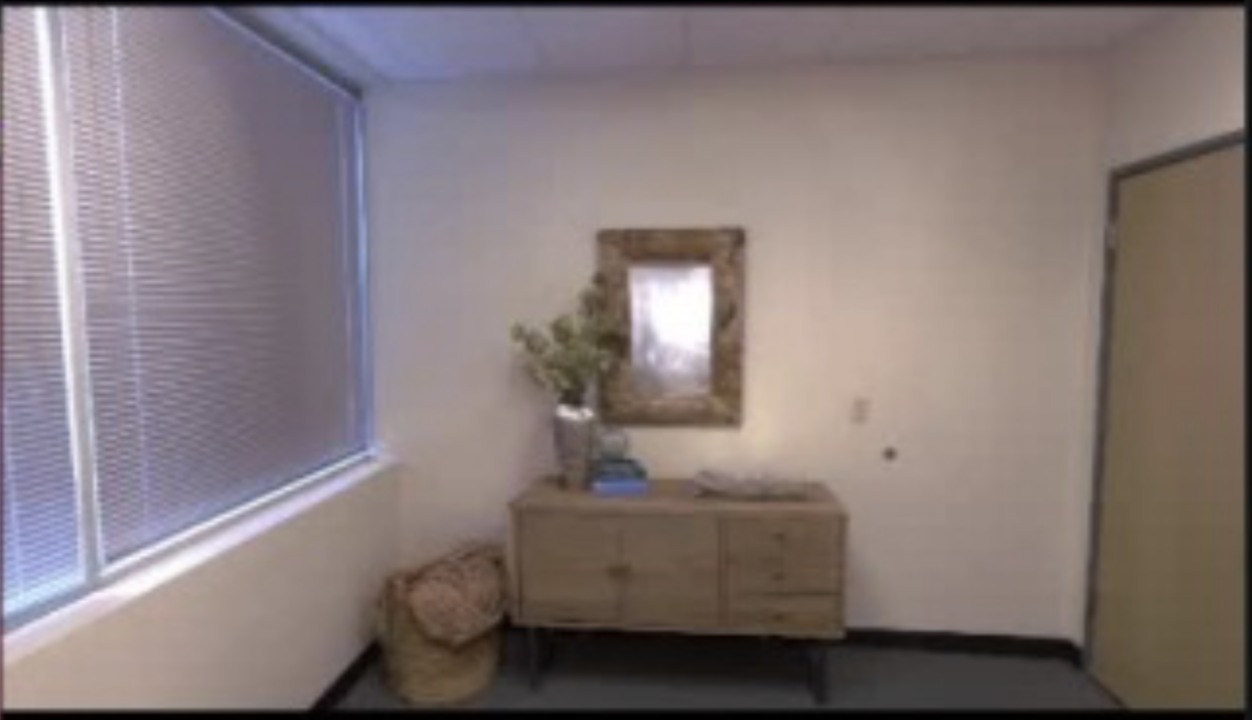

In [ ]:
image_file = "/content/Screenshot 2025-11-19 at 2.01.17 PM.png"
from IPython.display import Image
Image(image_file, width=640)

In [ ]:
with torch.no_grad():
    res = model.infer(
        tokenizer,
        prompt=prompt,
        image_file=image_file,
        output_path=".",
        base_size=1024,
        image_size=1024,
        crop_mode=False,
        save_results=True,
        test_compress=False,
        eval_mode=False
    )

/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
NO PATCHES
<|ref|>Cabinet<|/ref|><|det|>[[403, 666, 675, 899]]<|/det|>
<|ref|>Potted Plant<|/ref|><|det|>[[403, 420, 512, 671]]<|/det|>
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 2/2 [00:00<00:00, 17331.83it/s]


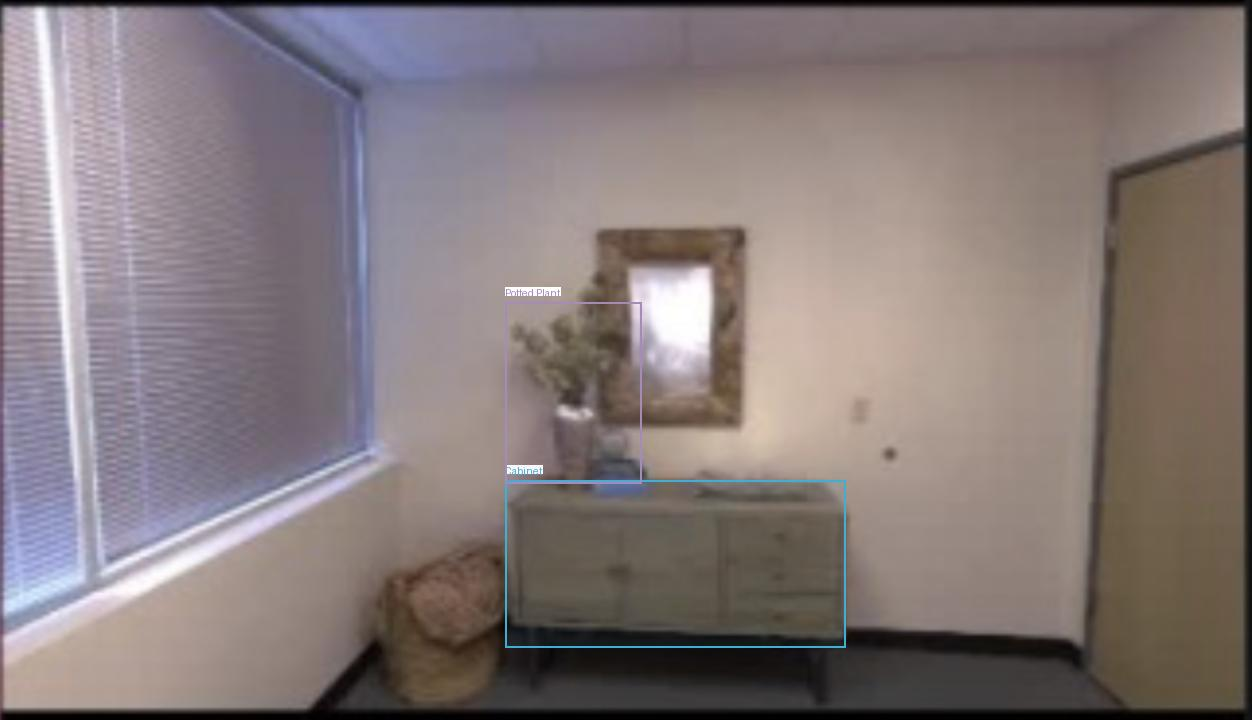

In [ ]:
Image("result_with_boxes.jpg", width=640)

In [ ]:
"""
Integrated Pipeline: Encoder-Decoder → ConceptGraph Detection Format
Generates complete detection results compatible with ConceptGraph's expected format.
"""

import os
import json
import torch
import itertools
import gzip
import pickle
import cv2
import numpy as np
from datetime import datetime
from pathlib import Path
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
from PIL import Image
import supervision as sv
from copy import deepcopy
import re
import open_clip

# ============================================================================
# CONFIGURATION
# ============================================================================
os.chdir('/content/drive/MyDrive/AER1515_Assignment1/project/')
IMAGE_INPUT_DIR = "./room1"  # Directory containing input images (jpg/png)
OUTPUT_BASE_DIR = "./logs"  # Base directory for logs


MODEL_NAME = 'deepseek-ai/DeepSeek-OCR'

# CLIP Model for feature extraction
CLIP_MODEL_NAME = "ViT-H-14"
CLIP_PRETRAINED = "laion2b_s32b_b79k"

# Generation Parameters
MAX_NEW_TOKENS = 64
TEMPERATURE = 0.0

# Relationship Keywords
RELATION_KEYWORDS = [
    "on top of", "under", "next to", "beside", "in front of",
    "behind", "inside", "above", "below", "around",
    "attached to", "leaning against", "related to"
]

# ============================================================================
# DETECTION RESULT GENERATION
# ============================================================================

def parse_deepseek_detections(response_text, image_shape):
    """
    Parse DeepSeek-OCR response to extract bounding boxes and classes.

    Returns:
        xyxy: np.array of shape (N, 4) with bbox coordinates
        class_ids: np.array of shape (N,) with class indices
        confidences: np.array of shape (N,) with confidence scores
        class_names: list of detected class names
    """
    detections = []
    lines = response_text.split('\n')

    # Common indoor object classes
    known_classes = [
        'chair', 'table', 'desk', 'bed', 'sofa', 'lamp', 'monitor',
        'keyboard', 'mouse', 'book', 'pillow', 'towel', 'bin', 'trash can',
        'door', 'window', 'picture', 'tv', 'cabinet', 'shelf', 'refrigerator'
    ]

    current_detection = {}

    for line in lines:
        line = line.strip()
        if not line:
            if current_detection:
                detections.append(current_detection)
                current_detection = {}
            continue

        # Look for object mentions
        line_lower = line.lower()

        # Try to extract bounding box coordinates [x1, y1, x2, y2]
        bbox_match = re.search(r'\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]', line)
        if bbox_match:
            x1, y1, x2, y2 = map(int, bbox_match.groups())
            current_detection['bbox'] = [x1, y1, x2, y2]

        # Try to find class name
        for cls_name in known_classes:
            if cls_name in line_lower:
                current_detection['class_name'] = cls_name
                break

        # Try to extract confidence if present
        conf_match = re.search(r'confidence[:\s]+(\d+\.?\d*)%?', line_lower)
        if conf_match:
            conf_val = float(conf_match.group(1))
            if conf_val > 1:  # If percentage
                conf_val /= 100
            current_detection['confidence'] = conf_val

    if current_detection:
        detections.append(current_detection)

    # If no structured detections found, create dummy detections
    if not detections:
        print("Warning: No structured detections found, creating default detections")
        h, w = image_shape[:2]
        # Create a few default bounding boxes
        detections = [
            {'bbox': [w//4, h//4, 3*w//4, 3*h//4], 'class_name': 'unknown', 'confidence': 0.5}
        ]

    # Convert to arrays
    xyxy = np.array([d.get('bbox', [0, 0, 100, 100]) for d in detections], dtype=np.float32)
    class_names = [d.get('class_name', 'unknown') for d in detections]
    confidences = np.array([d.get('confidence', 0.7) for d in detections], dtype=np.float32)

    return xyxy, class_names, confidences


def create_masks_from_bboxes(xyxy, image_shape):
    """
    Create binary masks from bounding boxes.
    In real scenario, you'd use SAM or get masks from DeepSeek-OCR.
    """
    masks = []
    h, w = image_shape[:2]

    for bbox in xyxy:
        mask = np.zeros((h, w), dtype=bool)
        x1, y1, x2, y2 = bbox.astype(int)
        # Clamp coordinates
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        mask[y1:y2, x1:x2] = True
        masks.append(mask)

    return np.array(masks, dtype=bool)


def extract_image_crops(image_rgb, xyxy):
    """Extract image crops for each detection."""
    crops = []
    for bbox in xyxy:
        x1, y1, x2, y2 = bbox.astype(int)
        # Clamp coordinates
        h, w = image_rgb.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        crop = image_rgb[y1:y2, x1:x2]
        if crop.size == 0:  # Empty crop
            crop = np.zeros((224, 224, 3), dtype=np.uint8)
        crops.append(crop)

    return crops


def compute_clip_features_batched(image_rgb, detections, clip_model, clip_preprocess,
                                  clip_tokenizer, class_names, device):
    """
    Compute CLIP features for image crops and text labels.

    Returns:
        image_crops: List of cropped images
        image_feats: np.array of CLIP image features
        text_feats: np.array of CLIP text features
    """
    # Extract crops
    image_crops = extract_image_crops(image_rgb, detections['xyxy'])

    # Process image crops
    image_tensors = []
    for crop in image_crops:
        if crop.size == 0:
            crop = np.zeros((224, 224, 3), dtype=np.uint8)
        crop_pil = Image.fromarray(crop)
        crop_tensor = clip_preprocess(crop_pil).unsqueeze(0)
        image_tensors.append(crop_tensor)

    if len(image_tensors) > 0:
        image_tensors = torch.cat(image_tensors, dim=0).to(device)

        with torch.no_grad():
            image_feats = clip_model.encode_image(image_tensors)
            image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
            image_feats = image_feats.cpu().numpy()
    else:
        image_feats = np.zeros((0, 1024), dtype=np.float32)

    # Process text labels
    if len(class_names) > 0:
        text_tokens = clip_tokenizer(class_names).to(device)

        with torch.no_grad():
            text_feats = clip_model.encode_text(text_tokens)
            text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
            text_feats = text_feats.cpu().numpy()
    else:
        text_feats = np.zeros((0, 1024), dtype=np.float32)

    return image_crops, image_feats, text_feats


def extract_relationship(caption):
    """Extract relationship keyword from caption."""
    text = caption.lower()
    for kw in RELATION_KEYWORDS:
        if kw in text:
            return kw
    return "related to"


# ============================================================================
# OBJECT CLASSES MANAGER
# ============================================================================

class ObjectClasses:
    """Manages object classes and colors."""

    def __init__(self, classes_list, bg_classes=None):
        self.classes = classes_list
        self.bg_classes = bg_classes if bg_classes else ["wall", "floor", "ceiling"]
        self.class_to_color = {
            cls: list(np.random.rand(3)) for cls in classes_list
        }

    def get_classes_arr(self):
        return self.classes

    def get_bg_classes_arr(self):
        return self.bg_classes

    def get_class_color(self, idx):
        if idx < len(self.classes):
            return self.class_to_color[self.classes[idx]]
        return [0.5, 0.5, 0.5]

    def get_class_id(self, class_name):
        """Get class ID for a class name."""
        if class_name in self.classes:
            return self.classes.index(class_name)
        return -1


# ============================================================================
# ENCODER WITH FULL DETECTION GENERATION
# ============================================================================

class ObjectEncoder:
    """Detects objects and generates complete detection results."""

    def __init__(self, model_name, log_dir, clip_model, clip_preprocess, clip_tokenizer, device):
        self.log_dir = log_dir
        self.log_file = open(log_dir / "encoder_log.txt", "w")
        self.device = device

        # CLIP models
        self.clip_model = clip_model
        self.clip_preprocess = clip_preprocess
        self.clip_tokenizer = clip_tokenizer

        self.log("Initializing Object Encoder...")

        qc = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float
        )

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        self.model = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True,
            use_safetensors=True,
            device_map="auto",
            quantization_config=qc,
            torch_dtype=torch.float
        )
        self.model = self.model.eval()
        self.log("Encoder loaded!")

    def log(self, message):
        print(f"[ENCODER] {message}")
        self.log_file.write(f"{message}\n")
        self.log_file.flush()

    def process_image_full(self, image_path, obj_classes, output_name):
        """
        Process image and generate complete detection results.

        Returns dict with all required fields:
            - xyxy, confidence, class_id, mask
            - classes, image_crops, image_feats, text_feats
            - detection_class_labels, labels, edges, captions
        """
        self.log(f"Processing: {image_path}")

        # Load image
        image_rgb = cv2.imread(str(image_path))
        if image_rgb is None:
            self.log(f"Error: Could not load {image_path}")
            return None
        image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

        # Run detection
        prompt = "<image>\nIdentify all objects in the image and output them with bounding boxes."

        output_dir = self.log_dir / "encoder_outputs" / output_name
        output_dir.mkdir(exist_ok=True, parents=True)

        try:
            with torch.no_grad():
                res = self.model.infer(
                    self.tokenizer,
                    prompt=prompt,
                    image_file=str(image_path),
                    output_path=str(output_dir),
                    base_size=1024,
                    image_size=1024,
                    crop_mode=False,
                    save_results=True,
                    test_compress=False,
                    eval_mode=False
                )

            self.log(f"✓ Detection complete for {image_path.name}")

            # Save detection text
            result_file = output_dir / "detection_result.txt"
            with open(result_file, "w") as f:
                f.write(str(res))

        except Exception as e:
            self.log(f"✗ Error in detection: {str(e)}")
            return None

        # Parse detections
        xyxy, class_names, confidences = parse_deepseek_detections(str(res), image_rgb.shape)

        # Create class IDs
        class_ids = np.array([obj_classes.get_class_id(cn) for cn in class_names], dtype=int)
        # Handle unknown classes
        class_ids = np.where(class_ids == -1, 0, class_ids)

        # Create masks from bboxes
        masks = create_masks_from_bboxes(xyxy, image_rgb.shape)

        # Create supervision Detections object
        detections = {
            'xyxy': xyxy,
            'confidence': confidences,
            'class_id': class_ids,
            'mask': masks,
        }

        # Extract image crops and compute CLIP features
        image_crops, image_feats, text_feats = compute_clip_features_batched(
            image_rgb,
            detections,
            self.clip_model,
            self.clip_preprocess,
            self.clip_tokenizer,
            obj_classes.get_classes_arr(),
            self.device
        )

        # Create detection class labels
        detection_class_labels = [
            f"{obj_classes.get_classes_arr()[class_id]} {idx}"
            for idx, class_id in enumerate(class_ids)
        ]

        # Create labels (filtered, in this case same as detection_class_labels)
        labels = detection_class_labels.copy()

        # Generate dummy edges (will be replaced by decoder)
        edges = []

        # Generate dummy captions for now
        captions = [{'caption': f"{class_names[i]}"} for i in range(len(class_names))]

        # Build complete results dictionary
        results = {
            "xyxy": xyxy,
            "confidence": confidences,
            "class_id": class_ids,
            "mask": masks,
            "classes": obj_classes.get_classes_arr(),
            "image_crops": image_crops,
            "image_feats": image_feats,
            "text_feats": text_feats,
            "detection_class_labels": detection_class_labels,
            "labels": labels,
            "edges": edges,
            "captions": captions,
        }

        self.log(f"✓ Generated complete detection results: {len(xyxy)} objects")

        # Save results
        save_path = output_dir / "detection_results.pkl.gz"
        with gzip.open(save_path, 'wb') as f:
            pickle.dump(results, f)
        self.log(f"✓ Saved to {save_path}")

        return results, output_dir

    def close(self):
        self.log_file.close()


# ============================================================================
# DECODER: RELATIONSHIP GENERATION
# ============================================================================

class RelationshipDecoder:
    """Generates relationships between objects."""

    def __init__(self, model_name, log_dir):
        self.log_dir = log_dir
        self.log_file = open(log_dir / "decoder_log.txt", "w")
        self.log("Initializing Relationship Decoder...")

        qc = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float
        )

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        self.model = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True,
            use_safetensors=True,
            device_map="auto",
            quantization_config=qc,
            torch_dtype=torch.float
        )
        self.model = self.model.eval()
        self.log("Decoder loaded!")

    def log(self, message):
        print(f"[DECODER] {message}")
        self.log_file.write(f"{message}\n")
        self.log_file.flush()

    def build_pair_prompt(self, obj_a_name, obj_b_name):
        """Build simple prompt for relationship generation."""
        return f"""What is the spatial relationship between {obj_a_name} and {obj_b_name}?
Answer with a concise phrase like 'next to', 'on top of', 'behind', etc."""

    @torch.no_grad()
    def generate_caption(self, prompt):
        """Generate relationship caption."""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        out = self.model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=False,
            temperature=TEMPERATURE,
            pad_token_id=self.tokenizer.eos_token_id,
        )

        full_text = self.tokenizer.decode(out[0], skip_special_tokens=True)

        if full_text.startswith(prompt):
            return full_text[len(prompt):].strip()
        return full_text.strip()

    def process_detection_results(self, detection_results):
        """
        Generate relationships from detection results.
        Updates the 'edges' field in detection_results.
        """
        labels = detection_results['labels']
        class_names = [lbl.split()[0] for lbl in labels]  # Extract class name

        self.log(f"Generating relationships for {len(labels)} objects...")

        edges = []

        # Generate edges for all pairs
        for i, j in itertools.combinations(range(len(labels)), 2):
            obj_a_name = class_names[i]
            obj_b_name = class_names[j]

            prompt = self.build_pair_prompt(obj_a_name, obj_b_name)
            caption = self.generate_caption(prompt)
            relationship = extract_relationship(caption)

            # Edge format: (source_id, relationship, target_id)
            edges.append((i, relationship, j))

            self.log(f"  {i}:{obj_a_name} <{relationship}> {j}:{obj_b_name}")

        detection_results['edges'] = edges
        self.log(f"✓ Generated {len(edges)} relationships")

        return detection_results

    def close(self):
        self.log_file.close()


# ============================================================================
# SETUP AND UTILITIES
# ============================================================================

def setup_log_directory():
    """Create timestamped log directory."""
    timestamp = datetime.now().strftime("%y%m%d%H")
    log_dir = Path(OUTPUT_BASE_DIR) / f"log_{timestamp}"
    log_dir.mkdir(parents=True, exist_ok=True)

    (log_dir / "encoder_outputs").mkdir(exist_ok=True)
    (log_dir / "decoder_outputs").mkdir(exist_ok=True)
    (log_dir / "detections").mkdir(exist_ok=True)

    return log_dir


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """Run complete detection pipeline."""
    print("=" * 80)
    print("FULL DETECTION PIPELINE - CONCEPTGRAPH FORMAT")
    print("=" * 80)

    # Setup
    log_dir = setup_log_directory()
    print(f"\nLog directory: {log_dir}")

    # Check input
    if not Path(IMAGE_INPUT_DIR).exists():
        print(f"\n✗ Error: {IMAGE_INPUT_DIR} not found")
        return

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize CLIP
    print("\nLoading CLIP model...")
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
        CLIP_MODEL_NAME, CLIP_PRETRAINED
    )
    clip_model = clip_model.to(device)
    clip_tokenizer = open_clip.get_tokenizer(CLIP_MODEL_NAME)
    print("✓ CLIP loaded")

    # Setup object classes
    common_classes = [
        'chair', 'table', 'desk', 'bed', 'sofa', 'lamp', 'monitor',
        'keyboard', 'mouse', 'book', 'pillow', 'towel', 'bin',
        'door', 'window', 'picture', 'tv', 'cabinet', 'shelf',
        'refrigerator', 'unknown'
    ]
    obj_classes = ObjectClasses(common_classes)

    # Initialize encoder and decoder
    encoder = ObjectEncoder(
        MODEL_NAME, log_dir,
        clip_model, clip_preprocess, clip_tokenizer, device
    )
    decoder = RelationshipDecoder(MODEL_NAME, log_dir)

    # Get images
    image_dir = Path(IMAGE_INPUT_DIR)
    image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

    if not image_files:
        print(f"\n✗ No images found in {IMAGE_INPUT_DIR}")
        return

    print(f"\nFound {len(image_files)} images")

    # Process each image
    all_results = {}

    for idx, img_file in enumerate(image_files):
        print(f"\n{'='*80}")
        print(f"Processing {idx+1}/{len(image_files)}: {img_file.name}")
        print(f"{'='*80}")

        # STEP 1: Encoder - Generate detections with all fields
        output_name = img_file.stem
        detection_results, output_dir = encoder.process_image_full(
            img_file, obj_classes, output_name
        )

        if detection_results is None:
            continue

        # STEP 2: Decoder - Generate relationships
        detection_results = decoder.process_detection_results(detection_results)

        # Save final results
        final_save_path = log_dir / "detections" / f"{img_file.stem}.pkl.gz"
        final_save_path.parent.mkdir(exist_ok=True, parents=True)
        with gzip.open(final_save_path, 'wb') as f:
            pickle.dump(detection_results, f)

        print(f"\n✓ Saved complete detection results to {final_save_path}")

        # Also save as JSON for inspection
        json_save_path = final_save_path.with_suffix('.json')
        json_data = {
            'num_detections': len(detection_results['xyxy']),
            'detection_class_labels': detection_results['detection_class_labels'],
            'labels': detection_results['labels'],
            'edges': detection_results['edges'],
            'xyxy': detection_results['xyxy'].tolist(),
            'confidence': detection_results['confidence'].tolist(),
        }
        with open(json_save_path, 'w') as f:
            json.dump(json_data, f, indent=2)

        all_results[img_file.stem] = detection_results

    # Close
    encoder.close()
    decoder.close()

    # Summary
    print(f"\n{'='*80}")
    print("PIPELINE COMPLETE!")
    print(f"{'='*80}")
    print(f"Processed images: {len(all_results)}")
    print(f"\nOutputs in: {log_dir}")
    print(f"  - Detection PKL files: {log_dir / 'detections'}")
    print(f"  - Logs: encoder_log.txt, decoder_log.txt")

    print("\n" + "="*80)
    print("DETECTION RESULTS FORMAT:")
    print("="*80)
    if all_results:
        sample_key = list(all_results.keys())[0]
        sample_result = all_results[sample_key]
        print(f"\nFields in detection results:")
        for key in sample_result.keys():
            value = sample_result[key]
            if isinstance(value, np.ndarray):
                print(f"  - {key}: np.array {value.shape}")
            elif isinstance(value, list):
                print(f"  - {key}: list (len={len(value)})")
            else:
                print(f"  - {key}: {type(value).__name__}")

if __name__ == "__main__":
    main()

FULL DETECTION PIPELINE - CONCEPTGRAPH FORMAT

Log directory: logs/log_25112619
Using device: cuda

Loading CLIP model...


open_clip_model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

✓ CLIP loaded
[ENCODER] Initializing Object Encoder...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- configuration_deepseek_v2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


deepencoder.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- modeling_deepseekv2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


conversation.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- modeling_deepseekocr.py
- configuration_deepseek_v2.py
- deepencoder.py
- modeling_deepseekv2.py
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ENCODER] Encoder loaded!
[DECODER] Initializing Relationship Decoder...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


<div style="
background: linear-gradient(135deg, #e8f5e9, #f1f8e9);
border: 2px solid #4CAF50;
border-radius: 14px;
padding: 18px;
text-align: center;
color: #1b5e20;
font-family: 'Segoe UI', sans-serif;
font-size: 1.1em;
box-shadow: 0 4px 12px rgba(0,0,0,0.08);
">

<b>📘 Vision Class — Deep Learning & Computer Vision</b><br><br>

🔗 <a href="https://class.vision" target="_blank" style="color:#1b5e20; font-weight:600;">
https://class.vision</a><br><br>

📣 Telegram Channels:<br>
<a href="https://t.me/cvision" target="_blank" style="color:#2e7d32; font-weight:bold;">@cvision</a> |
<a href="https://t.me/class_vision" target="_blank" style="color:#2e7d32; font-weight:bold;">@class_vision</a> |
<a href="https://t.me/llm_huggingface" target="_blank" style="color:#2e7d32; font-weight:bold">@llm_huggingface</a>

</div>
